In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models,regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [3]:
run = wandb.init(
    project="driver-drowsiness",
    name="mobilenetv2_transfer4",
    config={
        "img_size": 224,
        "batch_size": 32,
        "epochs": 50,
        "optimizer": "AdamW",
        "architecture": "MobileNetV2",
        "learning_rate": 1e-5,
        "weight_decay":1e-3,
        "loss": "binary_crossentropy",
    }
)

config = wandb.config


In [4]:
train_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25, 
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    "../data/train",
    target_size=(config.img_size, config.img_size),
    batch_size=config.batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    "../data/val",
    target_size=(config.img_size, config.img_size),
    batch_size=config.batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    "../data/test",
    target_size=(config.img_size, config.img_size),
    batch_size=config.batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)


Found 1890 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


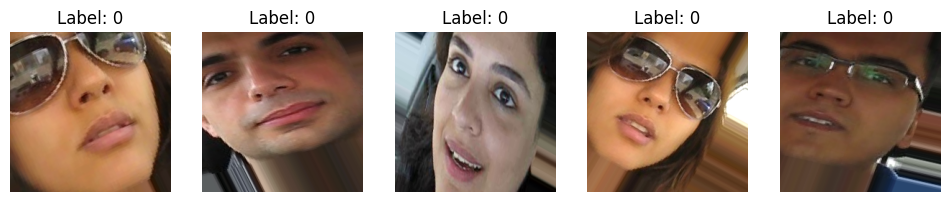

In [5]:
x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(1, 5, figsize=(12, 3))

for i in range(5):
    img = x_batch[i]

    # Reverse preprocess_input FOR VISUALIZATION ONLY
    img_vis = (img + 1.0) / 2.0        # [-1,1] -> [0,1]
    img_vis = np.clip(img_vis, 0, 1)

    axes[i].imshow(img_vis)
    axes[i].set_title(f"Label: {int(y_batch[i])}")
    axes[i].axis("off")

plt.show()


In [6]:
print(train_generator.class_indices)

{'normal': 0, 'yawn': 1}


In [7]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(config.img_size, config.img_size, 3)
)

base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [8]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])


model.compile(
    optimizer=AdamW(learning_rate=config.learning_rate, weight_decay=config.weight_decay),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=["accuracy", tf.keras.metrics.Recall(name="recall")]
)

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 1,060,673 (4.05 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True,
)

checkpoint = WandbModelCheckpoint(
    filepath="../models/mobilenet4/best.keras",
    monitor="val_loss",
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
)

callbacks = [
    early_stop,
    checkpoint,
    reduce_lr,
    WandbMetricsLogger()
]


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


In [11]:
weights = {0: 1.0, 1: 2.85}
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=config.epochs,
    class_weight=weights,
    callbacks=callbacks,
)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.5166 - loss: 5.3680 - recall: 0.6182 - val_accuracy: 0.7309 - val_loss: 4.8044 - val_recall: 0.3394 - learning_rate: 1.0000e-05
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5834 - loss: 5.2556 - recall: 0.6022 - val_accuracy: 0.7679 - val_loss: 4.7272 - val_recall: 0.3028 - learning_rate: 1.0000e-05
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.6375 - loss: 5.1450 - recall: 0.6774 - val_accuracy: 0.7951 - val_loss: 4.6684 - val_recall: 0.2936 - learning_rate: 1.0000e-05
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.7042 - loss: 5.0385 - recall: 0.7599 - val_accuracy: 0.8025 - val_loss: 4.6187 - val_recall: 0.3119 - learning_rate: 1.0000e-05
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.7182 - loss: 4.9792 - recall: 0.7185 - val_accuracy: 0.8247 - val_loss: 4.5702 - val_recall: 0.3945 - learning_rate: 1.0000e-05
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━

In [12]:
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.3).astype(int).ravel()
y_true = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step 


In [13]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)   # THIS IS CRITICAL
f1 = f1_score(y_true, y_pred)
print(f"accuracy_score:{acc}\nprecision_score:{prec}\nrecall_score:{rec}\nf1_score:{f1}")

accuracy_score:0.8452088452088452
precision_score:0.6643356643356644
recall_score:0.8636363636363636
f1_score:0.7509881422924901


In [14]:
wandb.log({
    "test_accuracy": acc,
    "test_precision": prec,
    "test_recall": rec,
    "test_f1": f1
})

In [15]:
class_names = list(test_generator.class_indices.keys())
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
)

print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

      normal     0.9432    0.8384    0.8877       297
        yawn     0.6643    0.8636    0.7510       110

    accuracy                         0.8452       407
   macro avg     0.8038    0.8510    0.8193       407
weighted avg     0.8678    0.8452    0.8508       407



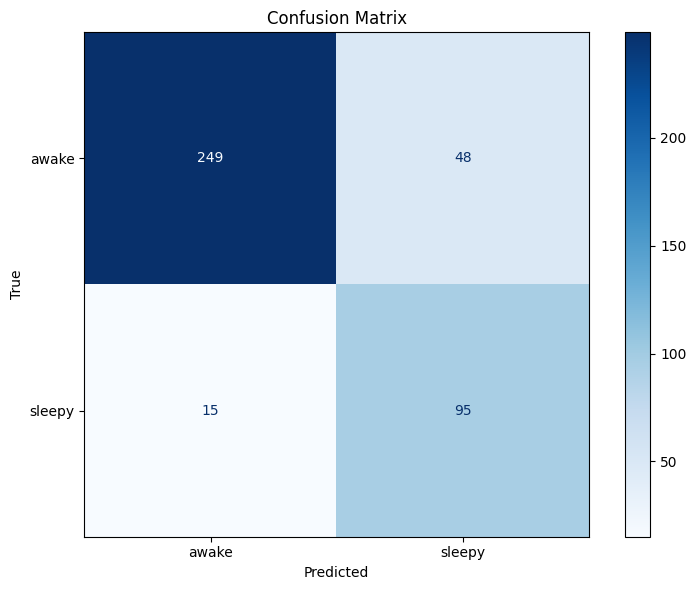

In [16]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(cm, display_labels=['awake','sleepy'])
cmd.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
with open("../models/mobilenet4/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [18]:
wandb.finish()

epoch/accuracy,▁▂▃▄▅▆▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch/recall,▁▁▃▅▃▅▅▅▆▄▇▇▆▆▆▆▆▇▇▇▆▆▇▇▇▆▇▇█▇█▇▇▇▇▇▇▇██
epoch/val_accuracy,▁▂▃▄▄▆▆▆▆▆▇▇▇▇██▇█▇█████████████████▇███
epoch/val_loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch/val_recall,▂▁▁▁▂▄▄▅▅▅▆▆▆▆▆██▇▇▇██████████▇▇████▇▇█▇
test_accuracy,▁
test_f1,▁
+2,...
